# Cuaderno de pruebas para tratamiento de formas de onda
## IDENTIFICACION y LOCALIZACION de Tremors No Volcanicos (TNV) en el Valle Medio del Magdalena (VMM)
## Curaduria de Sismicidad - Centro de Transparencia (CDT)
### Autor: Jose Manuel Ramirez Martinez
### Correo: josmramirezmar@unal.edu.co

In [2]:
# Declaracion de las librerias
try: 
    import time
    t=time.time()
    print("Cargando librerias...")
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import cartopy
    from threading import Thread
    import obspy
    from obspy.clients.fdsn import Client as ClientF 
    from obspy import UTCDateTime,Stream,read_inventory
    from obspy.signal.trigger import z_detect,plot_trigger
    from xcorr import correlate_maxlag, correlate_template, get_lags
    secs = time.time() - t
    print(f"Librerias cargadas en {secs} segundos.")
except Exception as e:
    print("Error cargando una libreria:", str(e))

Cargando librerias...
Librerias cargadas en 7.0113465785980225 segundos.


In [3]:
# Lectura del Inventario
inv = read_inventory("..\\archivo\\dataless\\CM.CDT.04.dataless")
inv = inv.select(channel="[HH]*")
print(inv)

Inventory created at 2022-06-10T14:53:49.638956Z
	Created by: ObsPy 1.3.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.3.0
	Contains:
		Networks (1):
			CM
		Stations (11):
			CM.AGCC (Aguachica, Cesar, Colombia)
			CM.EZNC (La Esperanza, Norte de Santander, Colombia)
			CM.OCA (Ocana, Norte de Santander, Colombia)
			CM.PTB (Puerto Berrio, Antioquia, Colombia)
			CM.VMM05 (San Martin, Cesar, Colombia)
			CM.VMM07 (Puerto Wilches, Santander, Colombia)
			CM.VMM09 (Lebrija, Santander, Colombia)
			CM.VMM10 (El Carmen de Chucuri, Santander, Colombia)
			CM.VMM11 (Sabana de Torres, Santander)
			CM.VMM12 (Simiti,Bolivar)
			CM.ZAR (Zaragoza, Antioquia, Colombia)
		Channels (72):
			CM.AGCC.00.HHZ, CM.AGCC.00.HHN, CM.AGCC.00.HHE, CM.EZNC.00.HHZ (2x)
			CM.EZNC.00.HHN (2x), CM.EZNC.00.HHE (2x), CM.OCA.00.HHZ (3x), 
			CM.OCA.00.HHN (3x), CM.OCA.00.HHE (3x), CM.OCA.10.HNZ (3x), 
			CM.OCA.10.HNN (3x), CM.OCA.10.HNE (3x), CM.PTB.00.HHZ (5x), 
			CM.PTB.00

In [4]:
# Parametros Estaciones del Servicio Geologico Colombiano (SGC)
clientCM = ClientF('http://sismo.sgc.gov.co:8080/')
network = "CM"
#stations = ("CHI","NOR","ROSC","RUS","CVER","VIL","SJC","ZAR","PTB","GUY2C","SPBC","AGCC","EZNC","VMM09","VMM05","VMM07","VMM10","LL8C","VMM11","VMM12","OCA","BRJC")
stations = ("ZAR","PTB","AGCC","EZNC","VMM09","VMM05","VMM07","VMM10","VMM11","VMM12","OCA")
channels = ("HHN","HHE","HHZ")
locIds = "*"
dateStart = UTCDateTime("2022-06-01T00:00:00")
DateEnd = dateStart + (4*60)

In [5]:
# Directorio de resultados
dirPath = os.getcwd()
dirResultado = "Resultados\\" + dateStart.strftime("%Y%m%dT%H%M")
mseedName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M")
dirMseed = os.path.join(dirPath, dirResultado, mseedName)
dirFull = os.path.dirname(dirMseed)

if not os.path.exists(dirFull):
    os.makedirs(dirFull)
    print("Creado el directorio " + dirFull)
else: 
    print("Directorio " + dirFull + " existente.")

Directorio g:\Mi unidad\RSUNAL\TNV\Python\TNV\TNVgit\TNV\cuadernos\Resultados\20220601T0000 existente.


In [6]:
# Carga de Stream
st = Stream()
for sta in stations:
    for cha in channels:
        try:
            st += clientCM.get_waveforms('CM', sta, '*', cha, dateStart, DateEnd)
        except Exception as e:
            print("Error obteniendo el " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " del canal " + str(cha) + " de la estacion " + str(sta) + ": " + str(e))

# Impresion en consola
print(st.__str__(extended=True))

# Almacenado temporal
try:
    st.write(dirMseed, format="MSEED")
    print("mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " almacenado correctamente.")
except Exception as e:
    print("Error almacenando el mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))


Error obteniendo el 2022-06-01T00:00 del canal HHN de la estacion AGCC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHE de la estacion AGCC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHZ de la estacion AGCC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHN de la estacion EZNC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHE de la estacion EZNC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHZ de la estacion EZNC: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error obteniendo el 2022-06-01T00:00 del canal HHN de la estacio

In [7]:
# Plot RAW
rawName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_RAW.png"
dirRaw = os.path.join(dirPath, dirResultado, rawName)

# Seleccion de componente
#st = st.select(component="Z")

try:
    st.plot(method='full', equal_scale=False, outfile=dirRaw)
    print("RAW mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando el RAW mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

RAW mseed del 2022-06-01T00:00 ploteado correctamente.


In [8]:
# Plot DETREND
detName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_DET.png"
dirDet = os.path.join(dirPath, dirResultado, detName)

try:
    st.detrend()
    st.plot(method='full', equal_scale=False, outfile=dirDet)
    print("DETREND mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando el DETREND del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

DETREND mseed del 2022-06-01T00:00 ploteado correctamente.


In [9]:
# Plot FILTRO
filName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_FIL.png"
dirFil = os.path.join(dirPath, dirResultado, filName)

try:
    st.filter("bandpass", freqmin=1, freqmax=10, corners=2, zerophase=True)
    st.plot(method='full', equal_scale=False, outfile=dirFil)
    print("FILTRAO mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando el FILTRADO del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

FILTRAO mseed del 2022-06-01T00:00 ploteado correctamente.


In [10]:
# Plot RESPUESTA INSTRUMENTAL
RIName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_RI.png"
dirRI = os.path.join(dirPath, dirResultado, RIName)

try:
    st.remove_response(inventory=inv, output="DEF", water_level=60, fig=dirRI)
    print("RESPUESTA INSTRUMENTAL mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando LA RESPUESTA INSTRUMENTAL del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

RESPUESTA INSTRUMENTAL mseed del 2022-06-01T00:00 ploteado correctamente.


In [11]:
# Plot MERGE
MerName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_MER.png"
dirMer = os.path.join(dirPath, dirResultado, MerName)


try:
    st.merge(method=1, fill_value='interpolate', interpolation_samples=-1)
    st.plot(method='full', equal_scale=False, outfile=dirMer)
    print("Trazas del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " unidas correctamente.")
except Exception as e:
    print("Error unindo las trazas del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

Trazas del 2022-06-01T00:00 unidas correctamente.


In [12]:
# Plot NORMALIZADO
norName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_NOR.png"
dirNor = os.path.join(dirPath, dirResultado, norName)

try:
    st.normalize(global_max=False) 
    st.plot(method='full', equal_scale=False, outfile=dirNor)
    print("NORMALIZADO mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando el NORMALIZADO del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))


NORMALIZADO mseed del 2022-06-01T00:00 ploteado correctamente.


In [15]:
# Plot COMPONENTE Z
zName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_Z.png"
dirZ = os.path.join(dirPath, dirResultado, zName)

try:
    st2 = st.select(component="Z")
    st2.plot(method='full', equal_scale=False, outfile=dirZ)
    print("COMPONENTE Z mseed del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
except Exception as e:
    print("Error ploteando el COMPONENTE Z del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))

COMPONENTE Z mseed del 2022-06-01T00:00 ploteado correctamente.


_CORR_OCA-OCA del 2022-06-01T00:00 ploteado correctamente.
_CORR_OCA-PTB del 2022-06-01T00:00 ploteado correctamente.
_CORR_OCA-ZAR del 2022-06-01T00:00 ploteado correctamente.
_CORR_PTB-OCA del 2022-06-01T00:00 ploteado correctamente.
_CORR_PTB-PTB del 2022-06-01T00:00 ploteado correctamente.
_CORR_PTB-ZAR del 2022-06-01T00:00 ploteado correctamente.
_CORR_ZAR-OCA del 2022-06-01T00:00 ploteado correctamente.
_CORR_ZAR-PTB del 2022-06-01T00:00 ploteado correctamente.
_CORR_ZAR-ZAR del 2022-06-01T00:00 ploteado correctamente.


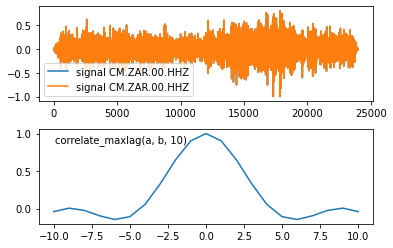

In [43]:
# CORRELACION CRUZADA (xcorr)
maxlag = 10

for tr1 in st2:
    a = tr1.data
    aName = tr1.id
    
    for tr2 in st2:
        b = tr2.data
        bName = tr2.id
        
        corrName = network + "_" + dateStart.strftime("%Y-%m-%dT%H-%M") + "_CORR_" + aName[3:-7] + "-" + bName[3:-7] + ".png"
        dirCORR = os.path.join(dirPath, dirResultado, corrName)
        
        try:
            cc1 = correlate_maxlag(a, b, maxlag)

            grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.3)
            ax1 = plt.subplot(grid[0, 0])
            ax2 = plt.subplot(grid[1, 0])
            ax1.plot(np.arange(len(a)), a, label='signal {}'.format(aName))
            ax1.plot(np.arange(len(b)), b, label='signal {}'.format(bName))
            ax2.plot(get_lags(cc1), cc1)
            ax1.legend(loc=3)
            kw = dict(xy=(0.05, 0.95), xycoords='axes fraction', va='top')
            ax2.annotate('correlate_maxlag(a, b, {})'.format(maxlag), **kw)
            plt.savefig(dirCORR)
            
            print("_CORR_" + aName[3:-7] + "-" + bName[3:-7] + " del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + " ploteado correctamente.")
        except Exception as e:
            print("Error ploteando _CORR_" + aName[3:-7] + "-" + bName[3:-7] + " del " + str(dateStart.strftime("%Y-%m-%dT%H:%M")) + ": " + str(e))


In [ ]:
#df = st[1].stats.sampling_rate
#cft = z_detect(st[1].data, int(10 * df))
#plot_trigger(st[1], cft, 0.5, 0.5)